# Data Science Fellowship program exam

**Machine Learning - Assignment 2: Natural disasters dataset**

By: Jules Kuehn

Due: 2020-12-03, 6pm Eastern

In [252]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [259]:
import sys
!{sys.executable} -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### Exploratory data analysis

In [260]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             classification_report, confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [172]:
train = pd.read_csv('../data/raw/train.csv')
train

id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...       1  
7611  Police investigating after an e-bike collided ...       1  
7612  The Latest: More Homes Razed by Northern Calif...       1  

[7613 rows x 5 columns]

In [173]:
disaster_tweets = train[train['target'] == 1]
non_disaster_tweets = train[train['target'] == 0]

print(f'{len(disaster_tweets)} non-disaster tweets')
print(f'{len(non_disaster_tweets)} disaster tweets')

3271 non-disaster tweets
4342 disaster tweets


There are a lot of numbers in disaster tweets. Rather than strip them out, let's replace with the word "number".

Let's also get rid of hashtags, @ symbols, clean up spacing and lowercase.

In [174]:
train['text'] = (train['text']
    .str.replace('\d+', ' number ')
    .str.replace('#', ' hashtag ')
    .str.replace('@', ' at ')
    # .str.replace('[^a-zA-Z]', ' ') # Might contain accented characters
    .str.replace('\ +', ' ')
    .str.lower()
)

C:\Users\JKUEHN\AppData\Local\Temp\ipykernel_14640\2045915524.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('\d+', ' number ')
C:\Users\JKUEHN\AppData\Local\Temp\ipykernel_14640\2045915524.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('\ +', ' ')


In [175]:
# Bag of words approach
bow_transformer = CountVectorizer().fit(train['text'])

# How many words?
print(f'{len(bow_transformer.vocabulary_)} words in the vocabulary')

22230 words in the vocabulary


In [176]:
# Words in the disaster tweets
disaster_transformer = CountVectorizer().fit(disaster_tweets['text'])

# Words in the non-disaster tweets
non_disaster_transformer = CountVectorizer().fit(non_disaster_tweets['text'])

# How many words in the disaster tweets?
print(f'{len(disaster_transformer.vocabulary_)} words in the disaster vocabulary')

# How many words in the non-disaster tweets?
print(f'{len(non_disaster_transformer.vocabulary_)} words in the non-disaster vocabulary')

11498 words in the disaster vocabulary
14278 words in the non-disaster vocabulary


In [177]:
# Create word clouds from tweets
def create_word_cloud(texts, transformer, common_words=[], debug=False):
    """
    Create a word cloud from a list of texts and CountVectorizer transformer.
    """

    # Get word frequencies from the CountVectorizer transformer
    bow = transformer.fit_transform(texts)
    word_freqs = dict(zip(
        transformer.get_feature_names_out(),
        np.asarray(bow.sum(axis=0))[0]
    ))

    if debug:
        # Print top words
        print('Top words:')
        print(sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:10])

    # Remove common words
    for word in common_words:
        word_freqs.pop(word, None)
    
    if debug and len(common_words) > 0:
        print('\nTop words after removing common words:')
        print(sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:10])

    # Create wordcloud from word frequencies
    wordcloud = WordCloud().generate_from_frequencies(word_freqs)

    # Display the generated image at a large size with no axes
    plt.figure(figsize=(20,10))
    plt.axis("off")
    plt.imshow(wordcloud, interpolation='bilinear')

Top words:
[('co', 2528), ('http', 2382), ('the', 1364), ('in', 1164), ('of', 928), ('to', 757), ('and', 506), ('on', 420), ('for', 401), ('is', 352)]


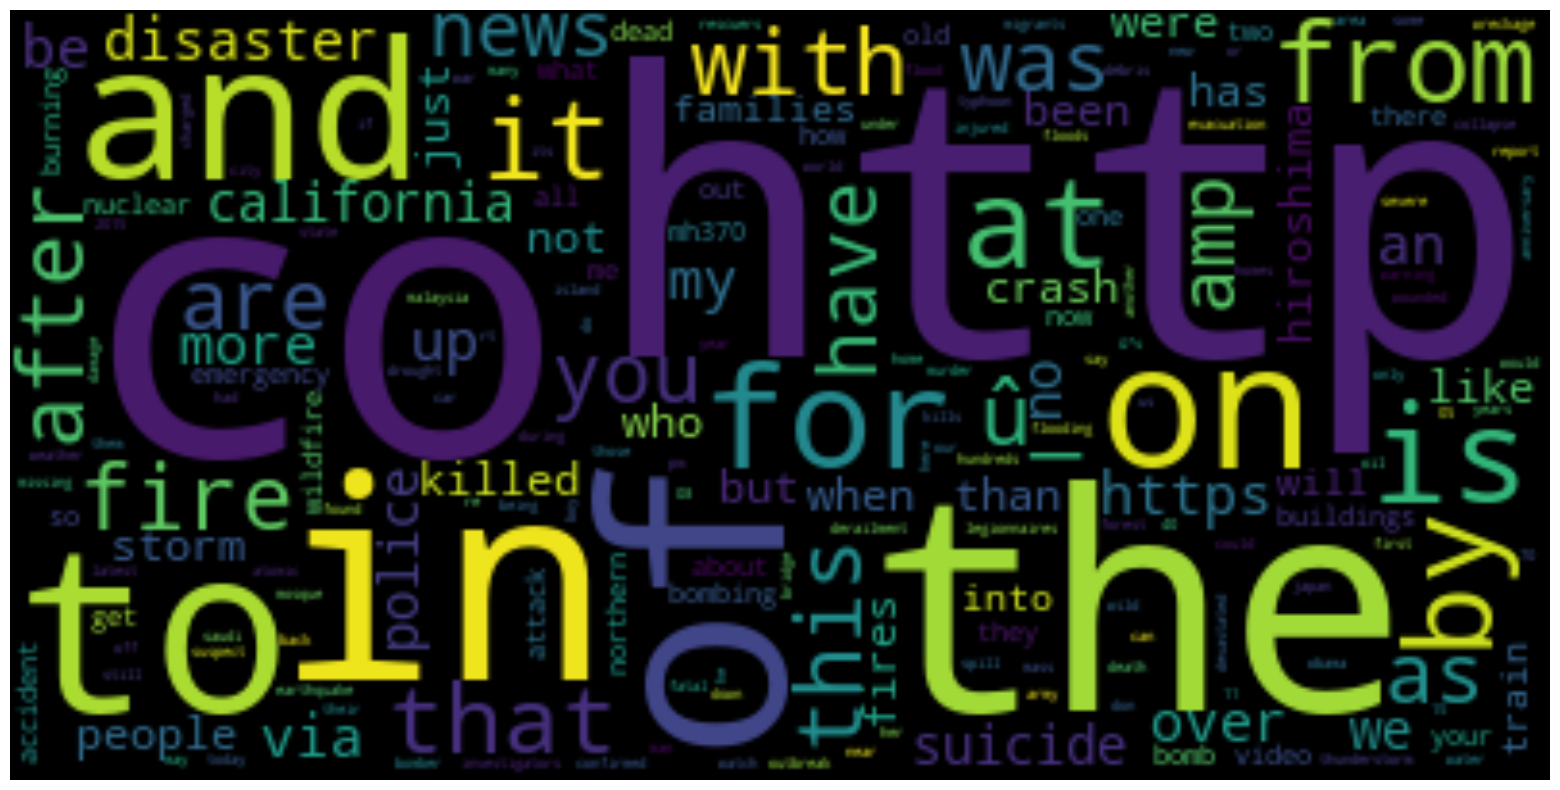

In [178]:
create_word_cloud(disaster_tweets['text'], disaster_transformer, debug=True)

Top words:
[('co', 2212), ('http', 1927), ('the', 1913), ('to', 1192), ('and', 920), ('of', 902), ('in', 822), ('you', 757), ('is', 598), ('my', 546)]


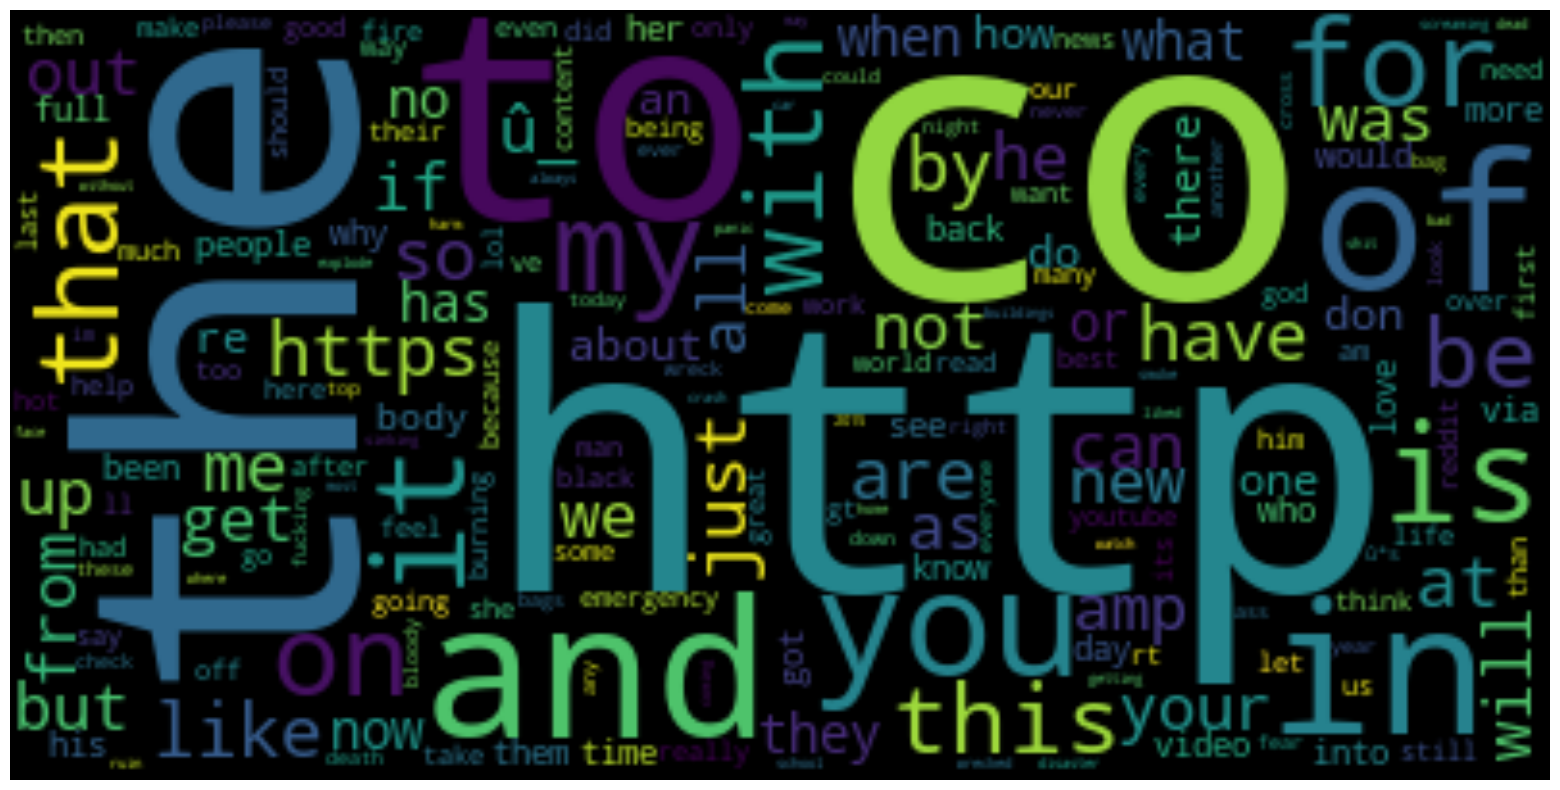

In [179]:
create_word_cloud(non_disaster_tweets['text'], non_disaster_transformer, debug=True)

#### Removing common words

We can see many of the most popular words are common between the non-disaster and disaster tweets.

Let's try removing the 50 most common words in the non-disaster tweets from both sets.

In [180]:
# Find most common words in non-disaster tweets
transformer = CountVectorizer().fit(non_disaster_tweets['text'])
bow = transformer.transform(non_disaster_tweets['text'])
word_freqs = dict(zip(
    transformer.get_feature_names_out(),
    np.asarray(bow.sum(axis=0))[0]
))

common_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:50]
print(common_words)

[('co', 2212), ('http', 1927), ('the', 1913), ('to', 1192), ('and', 920), ('of', 902), ('in', 822), ('you', 757), ('is', 598), ('my', 546), ('it', 539), ('for', 493), ('on', 440), ('that', 413), ('with', 380), ('this', 298), ('be', 287), ('https', 277), ('me', 263), ('like', 254), ('by', 249), ('so', 243), ('have', 242), ('are', 237), ('at', 234), ('just', 234), ('your', 231), ('but', 226), ('was', 217), ('amp', 209), ('not', 205), ('up', 200), ('out', 198), ('can', 196), ('all', 193), ('he', 185), ('if', 184), ('we', 179), ('will', 179), ('from', 177), ('û_', 176), ('new', 170), ('as', 164), ('get', 163), ('they', 159), ('or', 156), ('what', 152), ('no', 151), ('now', 147), ('when', 147)]


Top words:
[('co', 2528), ('http', 2382), ('the', 1364), ('in', 1164), ('of', 928), ('to', 757), ('and', 506), ('on', 420), ('for', 401), ('is', 352)]

Top words after removing common words:
[('fire', 182), ('after', 181), ('news', 140), ('over', 128), ('more', 124), ('an', 121), ('disaster', 121), ('via', 121), ('california', 115), ('suicide', 112)]


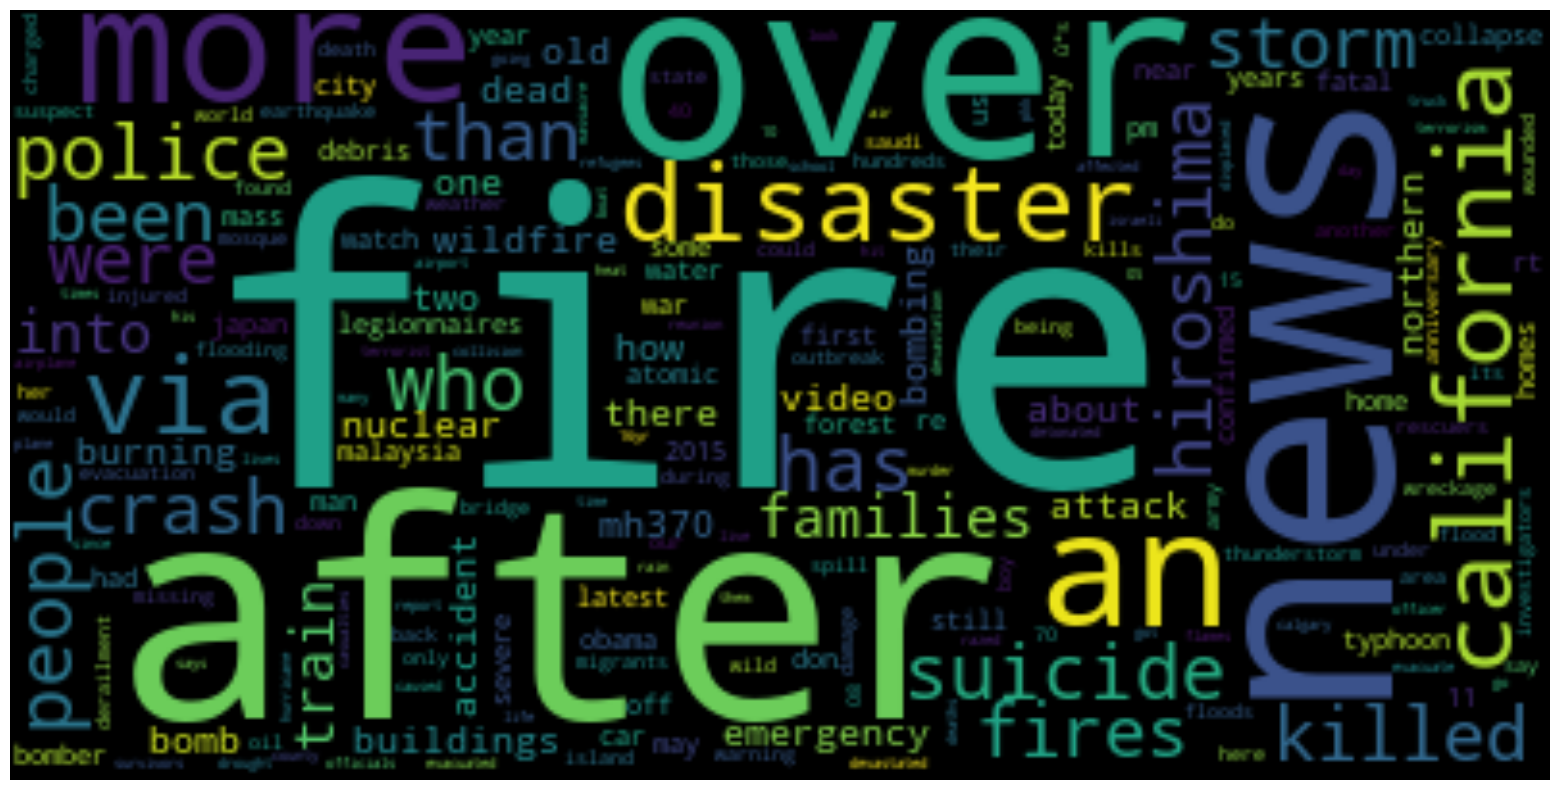

In [181]:
# Create word clouds without common words
create_word_cloud(disaster_tweets['text'], disaster_transformer, [word for word, freq in common_words], debug=True)

Top words:
[('co', 2212), ('http', 1927), ('the', 1913), ('to', 1192), ('and', 920), ('of', 902), ('in', 822), ('you', 757), ('is', 598), ('my', 546)]

Top words after removing common words:
[('has', 145), ('about', 139), ('don', 138), ('an', 131), ('one', 131), ('how', 130), ('do', 125), ('re', 117), ('there', 117), ('body', 116)]


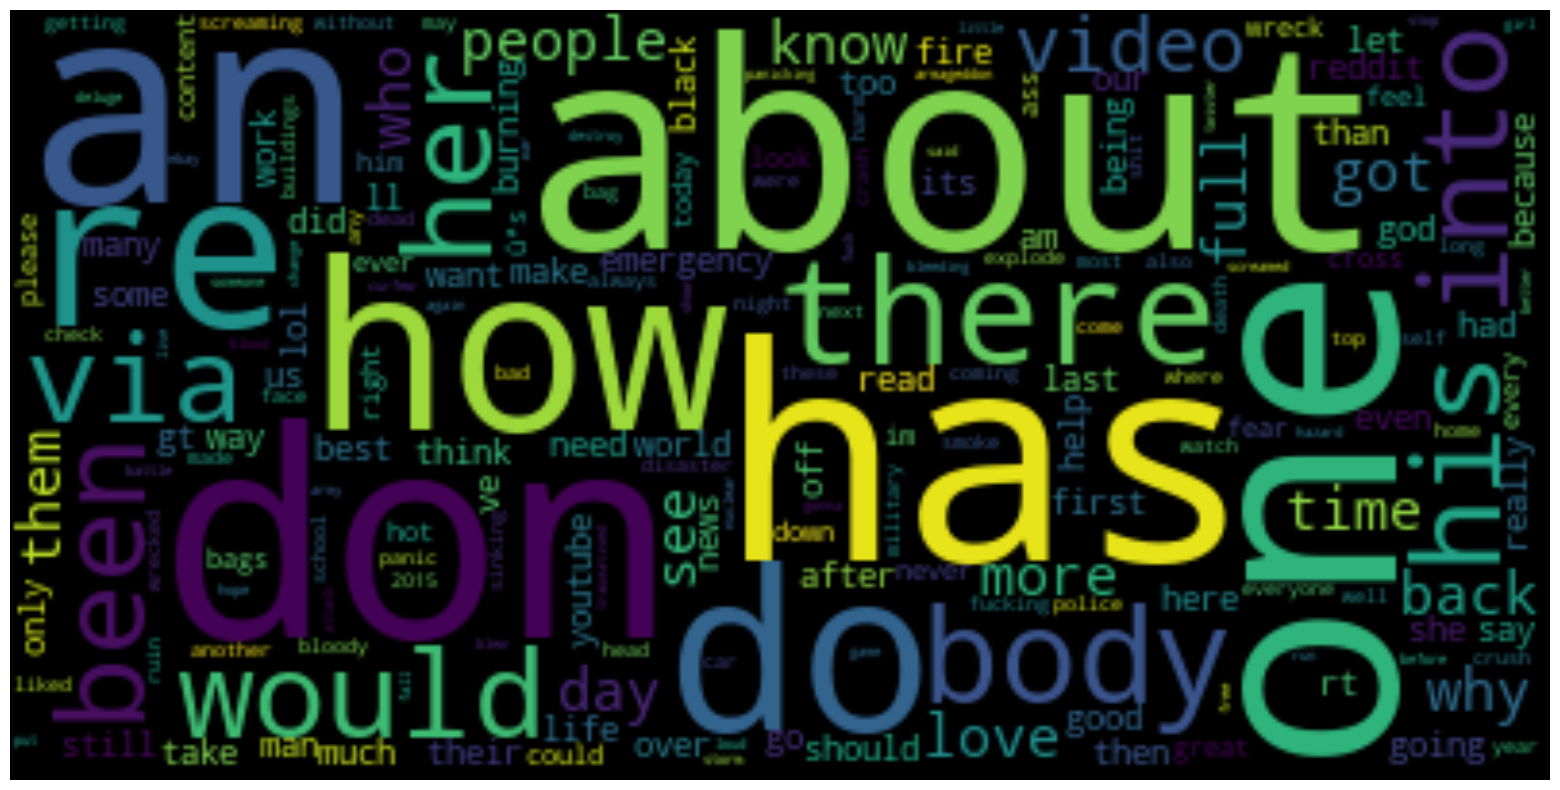

In [182]:
create_word_cloud(non_disaster_tweets['text'], non_disaster_transformer, [word for word, freq in common_words], debug=True)

Top words:
[('the', 1364), ('and', 506), ('for', 401), ('from', 245), ('that', 210), ('with', 192), ('fire', 182), ('this', 182), ('after', 181), ('was', 169)]


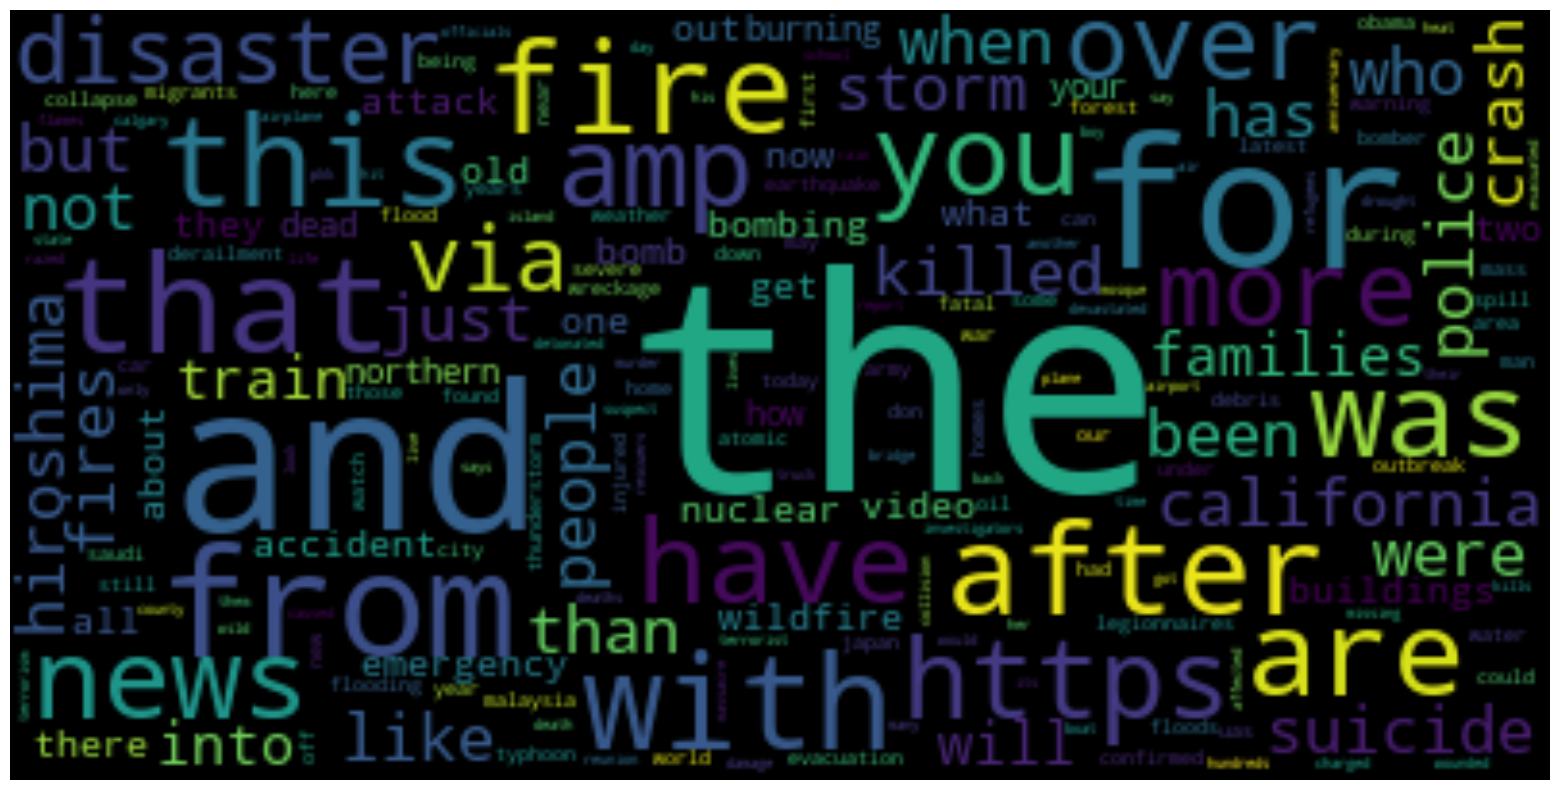

In [183]:
# Another way to remove (un)common words is to use max_df and min_df parameters
def param_vectorizer(kwargs={}):
    return CountVectorizer(
                strip_accents = 'unicode',
                # stop_words = 'english', # This was removing "fire"
                lowercase = True,
                token_pattern = r'\b[a-zA-Z]{3,}\b', # keeps words of 3 or more characters
                max_df = 0.5,
                min_df = 5,
                **kwargs
                )

# Words in the disaster tweets
disaster_transformer = param_vectorizer().fit(disaster_tweets['text'])

# Words in the non-disaster tweets
non_disaster_transformer = param_vectorizer().fit(non_disaster_tweets['text'])

create_word_cloud(disaster_tweets['text'], disaster_transformer, debug=True)

[('http', 1927), ('the', 1913), ('and', 920), ('you', 757), ('for', 493), ('that', 413), ('with', 380), ('this', 298), ('https', 277), ('like', 254), ('have', 242), ('are', 237), ('just', 234), ('your', 231), ('but', 226), ('was', 217), ('amp', 209), ('not', 205), ('out', 198), ('can', 196), ('all', 193), ('will', 179), ('from', 177), ('new', 170), ('get', 163), ('they', 159), ('what', 152), ('now', 147), ('when', 147), ('has', 145), ('about', 139), ('don', 138), ('one', 131), ('how', 130), ('there', 117), ('body', 116), ('would', 101), ('via', 99), ('her', 98), ('his', 98)]
Top words:
[('the', 1364), ('and', 506), ('for', 401), ('from', 245), ('that', 210), ('with', 192), ('fire', 182), ('this', 182), ('after', 181), ('was', 169)]

Top words after removing common words:
[('fire', 182), ('after', 181), ('news', 140), ('over', 128), ('more', 124), ('disaster', 121), ('california', 115), ('suicide', 112), ('police', 109), ('people', 105)]


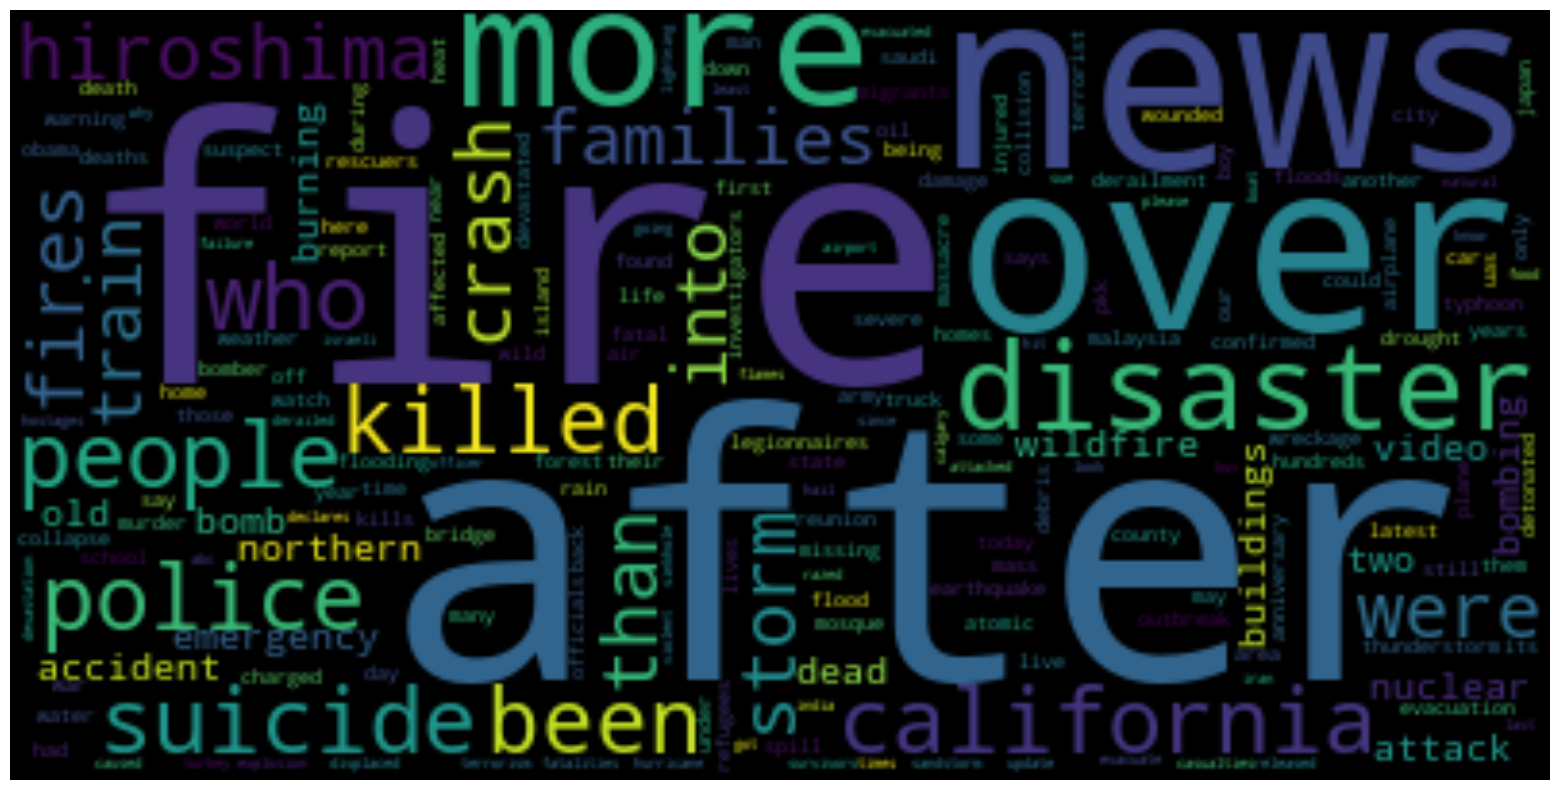

In [184]:
# Combining the approaches...
# Find most common words in non-disaster tweets
transformer = param_vectorizer().fit(non_disaster_tweets['text'])
bow = transformer.transform(non_disaster_tweets['text'])
word_freqs = dict(zip(
    transformer.get_feature_names_out(),
    np.asarray(bow.sum(axis=0))[0]
))

common_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:40]
print(common_words)

# Create word clouds without common words
create_word_cloud(disaster_tweets['text'], disaster_transformer, [word for word, freq in common_words], debug=True)

Top words:
[('http', 1927), ('the', 1913), ('and', 920), ('you', 757), ('for', 493), ('that', 413), ('with', 380), ('this', 298), ('https', 277), ('like', 254)]

Top words after removing common words:
[('been', 97), ('into', 96), ('video', 96), ('people', 95), ('more', 94), ('love', 90), ('who', 87), ('why', 87), ('day', 86), ('know', 86)]


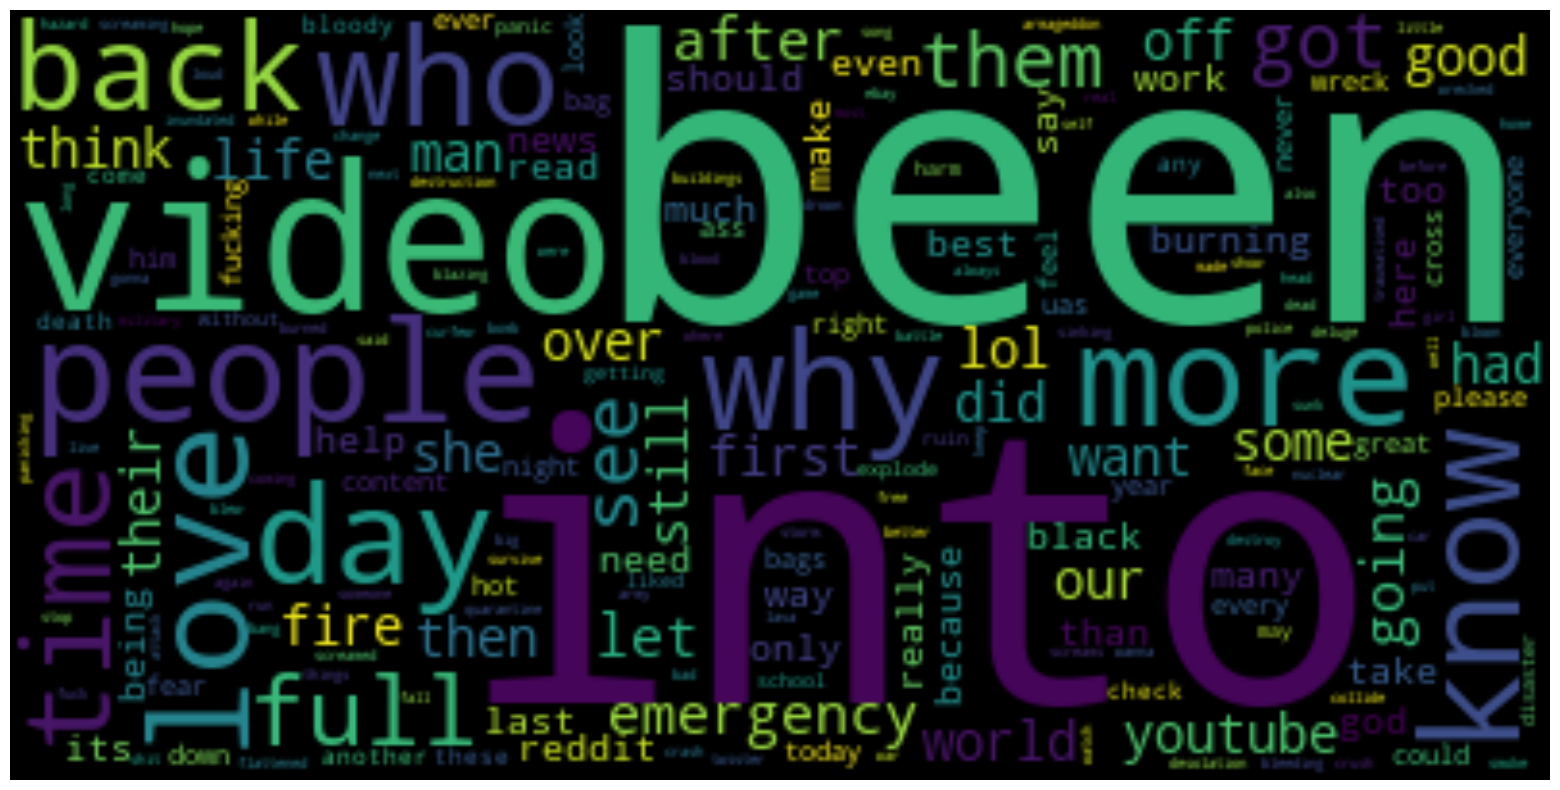

In [185]:
create_word_cloud(non_disaster_tweets['text'], non_disaster_transformer, [word for word, freq in common_words], debug=True)

In [236]:
# Set up final CountVectorizer for the entire dataset using the vocabulary from the disaster tweets
vocabulary = disaster_transformer.vocabulary_

# Remove common words from vocabulary
for word in [word for word, freq in common_words]:
    vocabulary.pop(word, None)

final_transformer = param_vectorizer(kwargs={
    'vocabulary': vocabulary.keys(),
    'binary': False
})

final_transformer.fit(train['text'])

# How many words?
print(f'{len(final_transformer.vocabulary_)} words in the vocabulary')

1337 words in the vocabulary


In [237]:
# Transform the text into a bag of words
train_bow = final_transformer.transform(train['text'])
train['bow'] = [row for row in train_bow.toarray()]

train_X = np.array(train['bow'].tolist())
train_y = np.array(train['target'].tolist())

# Split the data into training and validation sets
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

LogisticRegression:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



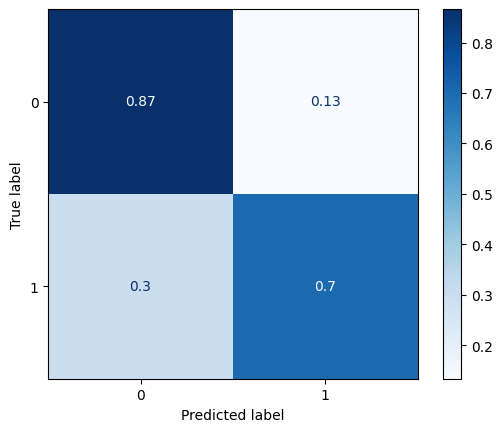

In [248]:
# Create a basic bag of words model using a logistic regression classifier
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(train_X, train_y)

# Make predictions on the training set
train_preds = model.predict(train_X)

# Make predictions on the validation set
val_preds = model.predict(val_X)

print('LogisticRegression:')
print(classification_report(val_y, val_preds))

# Confusion matrix with percentages
# ConfusionMatrixDisplay.from_estimator(model, train_X, train_y, cmap='Blues', normalize='true')
ConfusionMatrixDisplay.from_estimator(model, val_X, val_y, cmap='Blues', normalize='true')

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       874
           1       0.86      0.59      0.70       649

    accuracy                           0.78      1523
   macro avg       0.81      0.76      0.77      1523
weighted avg       0.80      0.78      0.78      1523



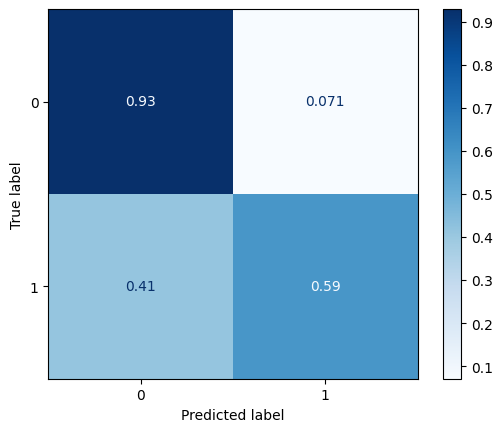

In [249]:
# Create a basic bag of words model using a random forest classifier
model = RandomForestClassifier(max_depth=100, random_state=42)
model.fit(train_X, train_y)

# Make predictions on the training set
train_preds = model.predict(train_X)

# Make predictions on the validation set
val_preds = model.predict(val_X)

print('RandomForestClassifier:')
print(classification_report(val_y, val_preds))

# ConfusionMatrixDisplay.from_estimator(model, train_X, train_y, cmap='Blues', normalize='true')
ConfusionMatrixDisplay.from_estimator(model, val_X, val_y, cmap='Blues', normalize='true')

In [140]:
import spacy
nlp = spacy.load("en_core_web_sm")

doc = nlp(u"Apples and oranges are similar. Boots and hippos aren't.")

for token in doc:
    print(token, token.lemma, token.lemma_)

Apples 8566208034543834098 apple
and 2283656566040971221 and
oranges 2208928596161743350 orange
are 10382539506755952630 be
similar 18166476740537071113 similar
. 12646065887601541794 .
Boots 9918665227421442029 boot
and 2283656566040971221 and
hippos 4133693291145879083 hippos
are 10382539506755952630 be
n't 447765159362469301 not
. 12646065887601541794 .
